In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score

In [17]:
df = pd.read_csv('./../data/preprocessed_matches.csv')
df.head()

,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome_label,...,home_pts_roll,away_gf_roll,away_ga_roll,away_pts_roll,h2h_avg_points_home,h2h_avg_points_away,rest_days_home,rest_days_away,rest_days_diff,target
0,803169,2015,2015-08-08 12:45:00,Manchester United,1,1,Tottenham Hotspur,6,0,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
1,803170,2015,2015-08-08 15:00:00,Everton,11,2,Watford,57,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
2,803162,2015,2015-08-08 15:00:00,Bournemouth,91,0,Aston Villa,7,1,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
3,803163,2015,2015-08-08 15:00:00,Norwich City,45,1,Crystal Palace,31,3,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
4,803167,2015,2015-08-08 15:00:00,Leicester City,13,4,Sunderland,56,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0


In [18]:
features = [
    'elo_home_pre', 'elo_away_pre', 'elo_diff_pre',
    'home_gf_roll', 'home_ga_roll', 'home_pts_roll',
    'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
]

In [19]:
# Remove 2015 (first season) from dataset because h2h calculations can't be performed (reasonably) without past games
df = df[df['season'] != 2015]
df['season'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [20]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "seed": 42,
    "learning_rate": 0.010007280241691709,
    "num_leaves": 127,
    "min_data_in_leaf": 100,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
}

In [21]:
# Timeseries Cross-Validation
seasons = df["season"].unique()
fold_accuracy = []
fold_logloss = []
fold_precision = []
fold_recall = []
train_sizes = []
train_scores = []
test_scores = []

for i in range(1, len(seasons)):
    train_df = df[df["season"].isin(seasons[:i])]
    test_df = df[df["season"].isin([seasons[i]])]

    X_train = train_df[features]
    y_train = train_df['target']
    X_test = test_df[features]
    y_test = test_df['target']

    lgb_tr = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(params, lgb_tr, num_boost_round=1000)

    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)

    pred_labels = (preds_test >= 0.5).astype(int)


    fold_accuracy.append(accuracy_score(y_test, pred_labels))
    fold_logloss.append(log_loss(y_test, preds_test))
    fold_precision.append(precision_score(y_test, pred_labels, average='binary'))
    fold_recall.append(recall_score(y_test, pred_labels, average='binary'))
    print(f"Lightgbm(n_estimators=500, max_depth=50) \n"
          f"Train({seasons[:i]}) with Test ({[seasons[i]]} \n"
          f"Accuracy: {accuracy_score(y_test, pred_labels)}, "
          f"Logloss: {log_loss(y_test, preds_test)}, "
          f"Precision: {precision_score(y_test, pred_labels, average='binary')}, "
          f"Recall: {recall_score(y_test, pred_labels, average='binary')}")

    train_sizes.append(len(train_df))
    test_scores.append(log_loss(y_test, preds_test))
    train_scores.append(log_loss(y_train, preds_train))

print("---------------------------Final---------------------------")
print(f"RandomForstClassifier(n_estimators=500, max_depth=50) "
      f"Accuracy: {np.mean(fold_accuracy)}, Logloss: {np.mean(fold_logloss)}, Precision: {np.mean(fold_precision)}, Recall: {np.mean(fold_recall)}")

Lightgbm(n_estimators=500, max_depth=50) 
Train([2016]) with Test ([2017] 
Accuracy: 0.7578947368421053, Logloss: 0.5175995082582686, Precision: 0.5888888888888889, Recall: 0.49074074074074076
Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017]) with Test ([2018] 
Accuracy: 0.7342105263157894, Logloss: 0.558293137193331, Precision: 0.6626506024096386, Recall: 0.4296875
Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017 2018]) with Test ([2019] 
Accuracy: 0.7236842105263158, Logloss: 0.5892229754482188, Precision: 0.5591397849462365, Recall: 0.4482758620689655
Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017 2018 2019]) with Test ([2020] 
Accuracy: 0.6263157894736842, Logloss: 0.7575136706526225, Precision: 0.5753424657534246, Recall: 0.27450980392156865
Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017 2018 2019 2020]) with Test ([2021] 
Accuracy: 0.7236842105263158, Logloss: 0.5606237534147461, Precision: 0.625, Recall: 0.46511627906976744
Lightgbm(n

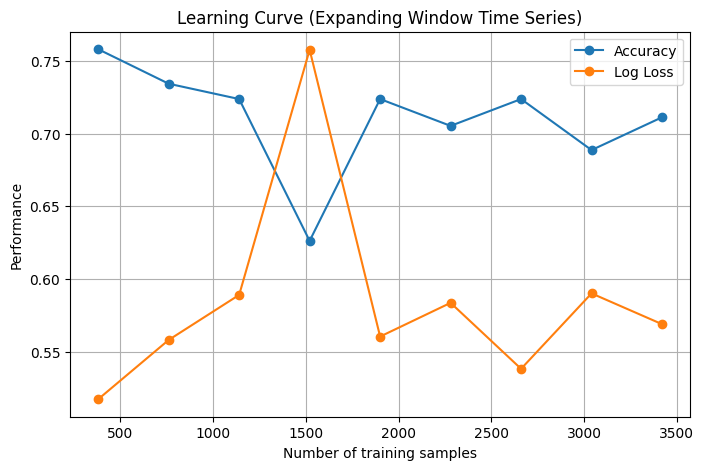

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, fold_accuracy, marker='o', label="Accuracy")
plt.plot(train_sizes, fold_logloss, marker='o', label="Log Loss")

plt.xlabel("Number of training samples")
plt.ylabel("Performance")
plt.title("Learning Curve (Expanding Window Time Series)")
plt.legend()
plt.grid(True)
plt.show()

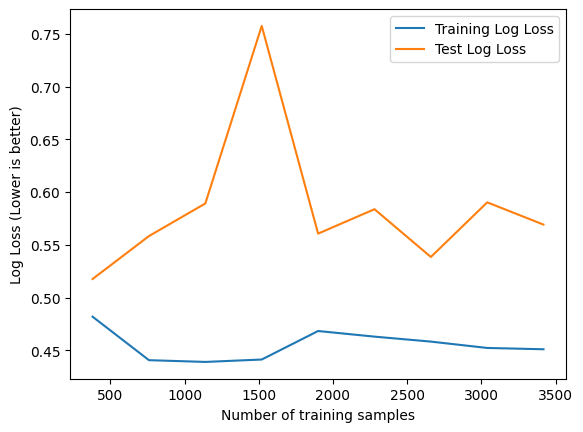

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_sizes, train_scores, label="Training Log Loss")
plt.plot(train_sizes, test_scores, label="Test Log Loss")
plt.xlabel("Number of training samples")
plt.ylabel("Log Loss (Lower is better)")
plt.legend()
plt.show()

In [33]:
train_seasons = seasons[:-1]
test_season = seasons[-1]
train_seasons, test_season

(array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]), 2025)

In [34]:
train_df = df[df["season"].isin(train_seasons)]
test_df = df[df["season"].isin([test_season])]

X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

lgb_tr = lgb.Dataset(X_train, label=y_train)
model = lgb.train(params, lgb_tr, num_boost_round=1000)

preds_test = model.predict(X_test)

pred_labels = (preds_test >= 0.5).astype(int)

fold_accuracy.append(accuracy_score(y_test, pred_labels))
fold_logloss.append(log_loss(y_test, preds_test))
fold_precision.append(precision_score(y_test, pred_labels, average='binary'))
fold_recall.append(recall_score(y_test, pred_labels, average='binary'))
print(f"Lightgbm(n_estimators=500, max_depth=50) \n"
    f"Train({seasons[:i]}) with Test ({[seasons[i]]} \n"
    f"Accuracy: {accuracy_score(y_test, pred_labels)}, "
    f"Logloss: {log_loss(y_test, preds_test)}, "
    f"Precision: {precision_score(y_test, pred_labels, average='binary')}, "
    f"Recall: {recall_score(y_test, pred_labels, average='binary')}")


Lightgbm(n_estimators=500, max_depth=50) 
Train([2016 2017 2018 2019 2020 2021 2022 2023 2024]) with Test ([2025] 
Accuracy: 0.7111111111111111, Logloss: 0.5691870113483517, Precision: 0.5428571428571428, Recall: 0.34545454545454546


,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome_label,...,away_pts_roll,h2h_avg_points_home,h2h_avg_points_away,rest_days_home,rest_days_away,rest_days_diff,target,y_true,y_pred,confidence
3799,2561895,2025,2025-08-15 20:00:00,Liverpool,14,4,Bournemouth,91,2,H_or_D,...,1.4,2.500000,0.437500,82.166667,82.166667,0.000000,0,0,0.177423,0.177423
3800,2561896,2025,2025-08-16 12:30:00,Aston Villa,7,0,Newcastle United,4,0,H_or_D,...,1.4,1.357143,1.357143,82.854167,82.854167,0.000000,0,0,0.178280,0.178280
3801,2561897,2025,2025-08-16 15:00:00,Brighton and Hove Albion,36,1,Fulham,54,1,H_or_D,...,1.2,0.700000,1.900000,82.958333,82.958333,0.000000,0,0,0.362549,0.362549
3802,2561899,2025,2025-08-16 15:00:00,Sunderland,56,3,West Ham United,21,0,H_or_D,...,1.4,0.500000,2.000000,3009.000000,82.958333,2926.041667,0,0,0.621931,0.621931
3803,2561900,2025,2025-08-16 15:00:00,Tottenham Hotspur,6,3,Burnley,90,0,H_or_D,...,0.8,2.285714,0.571429,82.958333,453.958333,-371.000000,0,0,0.229841,0.229841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3974,2562067,2025,2025-12-27 15:00:00,Burnley,90,0,Everton,11,0,H_or_D,...,1.2,1.357143,1.571429,7.000000,6.791667,0.208333,0,0,0.732377,0.732377
3975,2562070,2025,2025-12-27 15:00:00,Liverpool,14,2,Wolverhampton Wanderers,39,1,H_or_D,...,0.0,2.785714,0.214286,6.895833,7.000000,-0.104167,0,0,0.043146,0.043146
3976,2562068,2025,2025-12-27 17:30:00,Chelsea,8,1,Aston Villa,7,2,A,...,3.0,1.857143,1.000000,7.208333,6.041667,1.166667,1,1,0.377586,0.377586
3977,2562073,2025,2025-12-28 14:00:00,Sunderland,56,1,Leeds United,2,1,H_or_D,...,1.6,1.000000,1.000000,7.958333,7.750000,0.208333,0,0,0.436325,0.436325
